# Setup

In [1]:
import data
import model
import utils
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm_notebook
import torchvision.models as models
from sklearn.metrics import accuracy_score

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data Loading

In [3]:
dataset = data.dataset(image_root = './DRIMDB')
train_loader, val_loader = data.dataloader(dataset = dataset, batch_size = 16, validation_split = 0.2, shuffle_dataset = True)

# Sample visualization

In [4]:
train_iter = iter(train_loader)

In [5]:
samples, labels = train_iter.next()

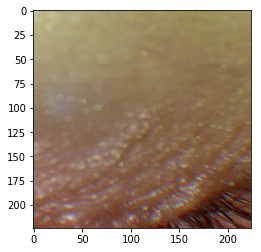

In [6]:
trial_num = np.random.randint(0, 4)
utils.imshow(samples[trial_num])

In [7]:
print(labels[trial_num])

Outlier


# Model

In [58]:
cnn = torchvision.models.alexnet(pretrained = True).to(device)
# cnn = model.AlexNet(num_classes = 3).to(device)

In [59]:
for param in cnn.parameters():
    param.requires_grad = False
cnn.classifier[-1] = nn.Linear(in_features = 4096, out_features = 3, bias = True)

In [60]:
cnn.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, 

In [61]:
for param in cnn.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([3, 4096])
torch.Size([3])


# Training

In [63]:
loss_fn = nn.CrossEntropyLoss()
optm = optim.SGD(cnn.parameters(), lr = 0.0005)
n_epochs = 10

In [64]:
loss_b = []
acc_b = []
loss_min = None
for epoch in tqdm_notebook(range(n_epochs)):

    for data in iter(train_loader):
        
        images, labels = data
        images = images.to(device)
        OH_labels = utils.encode_batch(labels)
        pred = cnn.forward(images)
        
        cnn.eval()
        acc = accuracy_score(torch.max(pred, 1)[1].cpu(), torch.max(OH_labels, 1)[1].cpu())
        acc_b.append(acc)
        
        cnn.train()
        loss = loss_fn(pred, torch.max(OH_labels, 1)[1])
        loss_b.append(loss.item())
        optm.zero_grad()
        loss.backward()
        optm.step()
        if loss_min == None:
            loss_min = loss.item()
        
        if loss.item() < loss_min:
            loss_min = loss.item()
#             print("Saving Checkpoint")
#             torch.save(cnn.state_dict(), 'checkpoint_min.pth')
        
        del images, labels, OH_labels, pred
        torch.cuda.empty_cache()
    print("|Epoch: {}/{}| |Loss: {:.4f}| |Train Acc: {:.4f}|".format(epoch, n_epochs, loss.item(), acc))

|Epoch: 0/10| |Loss: 0.6886| |Train Acc: 0.9231|
|Epoch: 1/10| |Loss: 0.7922| |Train Acc: 0.6923|
|Epoch: 2/10| |Loss: 0.4794| |Train Acc: 0.6923|
|Epoch: 3/10| |Loss: 0.3941| |Train Acc: 0.8462|
|Epoch: 4/10| |Loss: 0.3739| |Train Acc: 0.9231|
|Epoch: 5/10| |Loss: 0.1601| |Train Acc: 1.0000|
|Epoch: 6/10| |Loss: 0.2575| |Train Acc: 0.9231|
|Epoch: 7/10| |Loss: 0.1639| |Train Acc: 1.0000|
|Epoch: 8/10| |Loss: 0.4384| |Train Acc: 0.9231|
|Epoch: 9/10| |Loss: 0.1696| |Train Acc: 1.0000|



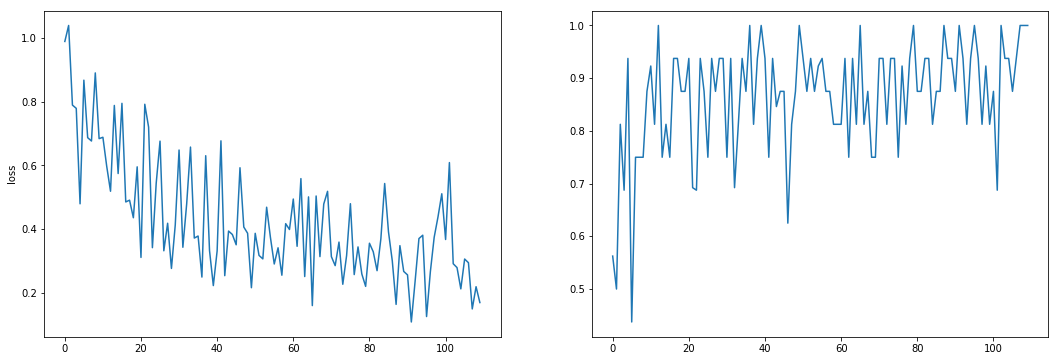

In [65]:
utils.visualize_results(loss_b, acc_b)

In [76]:
cnn.load_state_dict(torch.load('checkpoint_min.pth'))

<All keys matched successfully>

In [77]:
utils.evaluate(cnn, val_loader)

90.69767441860465


# GradCAM

In [86]:
config = dict(model_type='alexnet', arch=cnn, layer_name='features_11')
config['arch'].to(device).eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, 

In [87]:
# cams = [
#     [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
#     for config in configs
# ]
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp
from torchvision.utils import make_grid, save_image

gradcam, gradcam_pp = [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]

In [88]:
from PIL import Image
pil_img = Image.open('DRIMDB/good/drimdb_good (30).jpg')
# pil_img = pil_img.convert('RGB')
import torchvision.transforms as transforms
torch_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])(pil_img).to(device)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]

In [89]:
images = []
mask, _ = gradcam(normed_torch_img)
heatmap, result = visualize_cam(mask, normed_torch_img)

mask_pp, _ = gradcam_pp(normed_torch_img)
heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
    
grid_image = make_grid(images, nrow=5)

KeyError: 'value'

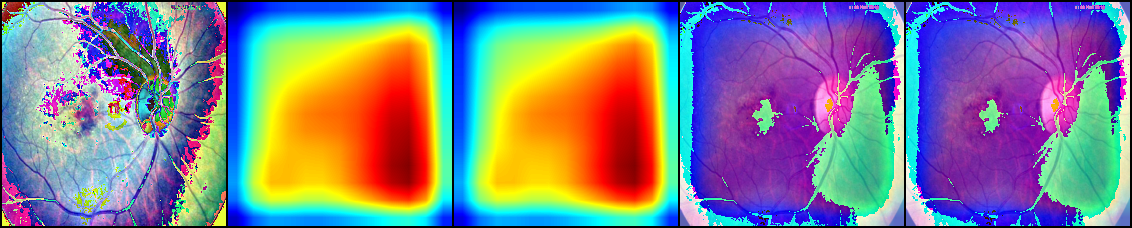

In [90]:
transforms.ToPILImage()(grid_image)